# Figure 4 | Spatially variable genes in the somatosensory nuclei

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import sys
sys.path.append('/code/')
from abc_merfish_analysis import abc_load as abc
from abc_merfish_analysis import ccf_images as cimg
from abc_merfish_analysis import ccf_erode as cerode
from abc_merfish_analysis import ccf_plots as cplots

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from matplotlib import rcParams
rcParams['ps.fonttype'] = 42
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 7

import colorcet as cc

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline') 

In [2]:
results_dir = '../../results'

## Load thalamus data

In [3]:
# Load the full thalamus anndata object
adata_th = abc.load_standard_thalamus(data_structure='adata')

# Subset to just the left hemisphere
adata_th_left = adata_th[adata_th.obs['left_hemisphere']].copy()

In [4]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'

x_col = 'x'+coords
y_col = 'y'+coords
section_col = z_col = 'z'+coords

In [5]:
# Load the CCF structures image
ccf_images = abc.get_ccf_labels_image()

# Merge substructures into structures (esp. AMd + AMv -> AM; LGd-co + LGd-ip + LGd-sh -> LG)
ccf_images = cerode.merge_substructures(ccf_images, ccf_level='structure')

# Precompute boundaries to use multiple times in this notebook w/o need to recompute
# we only need to load the boundaries for sections that contain the thalamus
sections_all = sorted(adata_th.obs[section_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_images, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )

In [6]:
# Load the CCF structures image - just the left hemisphere
ccf_images_left = abc.get_ccf_labels_image(subset_to_left_hemi=True)

# Merge substructures into structures (esp. AMd + AMv -> AM; LGd-co + LGd-ip + LGd-sh -> LG)
ccf_images_left = cerode.merge_substructures(ccf_images_left, ccf_level='structure')

# Precompute boundaries to use multiple times in this notebook w/o need to recompute
# we only need to load the boundaries for sections that contain the thalamus
sections_all = sorted(adata_th_left.obs[section_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries_left = cimg.sectionwise_label_erosion(ccf_images_left, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )

In [7]:
# if you reload abc_merfish_analysis.ccf_plots after this cell has been run, 
# cplots.CCF_REGIONS_DEFAULT will be reset to None & you'll need to re-run this cell
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names()

In [8]:
# load the published color palettes for the ABC Atlas taxonomy
abc_palettes = {level: abc.get_taxonomy_palette(level) for level in 
                ['neurotransmitter','class', 'subclass','supertype','cluster']}

# We have also provided a secondary color palette for the cluster level that 
# attempts to increase the color contrast between spatially negihboring clusters
# TODO: once released as package, this won't be accessible through a hardcode
palette_df = pd.read_csv('/code/abc_merfish_analysis/resources/cluster_palette_glasbey.csv')
abc_palettes['cluster'] = dict(zip(palette_df['Unnamed: 0'], palette_df['0']))

## Load data for just the Somatosensory cells

In [9]:
# get the cluster annotations for the somatosensory nuclei
nuclei_somatosensory = ['PO', 'VPM', 'VPL']
obs_annot = abc.get_obs_from_annotations(nuclei_somatosensory, 
                                         adata_th.obs, 
                                         taxonomy_level='cluster',
                                         core_clusters_only=False)

# use the list of ATN-specific clusters from obs_annot to filter & reset the 
# cluster col in the full anndata object
obs_annot.loc[:,'cluster'] = obs_annot.loc[:,'cluster'].cat.remove_unused_categories()
cluster_list_annot = sorted(obs_annot['cluster'].cat.categories)
# ATN-subset of the full anndata object
adata_annot = adata_th[adata_th.obs['cluster'].isin(cluster_list_annot)].copy()
# reset both cluster and supertype categories
for level in ['supertype','cluster']:
    adata_annot.obs.loc[:,level] = adata_annot.obs.loc[:,level].cat.remove_unused_categories()
    
# adata_annot.obs.loc[:,'cluster'] = adata_annot.obs.loc[:,'cluster'].cat.reorder_categories(cluster_list_annot, ordered=True)

In [10]:
sections_somatosensory = [7.2, 7.0, 6.8, 6.6, 6.4]  # anterior-to-posterior

print(f'sections as {z_col}: {sections_somatosensory}')
print(f'sections as brain_section_label: {abc.convert_section_list(sections_somatosensory)}')

sections as z_reconstructed: [7.2, 7.0, 6.8, 6.6, 6.4]
sections as brain_section_label: ['C57BL6J-638850.40', 'C57BL6J-638850.39', 'C57BL6J-638850.38', 'C57BL6J-638850.37', 'C57BL6J-638850.36']


## Figure 4A-B | Transcriptomic cell types in the somatosensory nuclei

In [11]:
# set kwargs for annotated cell type plots
kwargs_cell_types = dict(
    section_col=z_col,
    x_col=x_col,
    y_col=y_col,
    point_size=0.5,
    figsize=(4, 2),
    face_palette=None,
    edge_color='silver'
    )

### Figure 4A | Primary supertypes in somatosensory nuclei

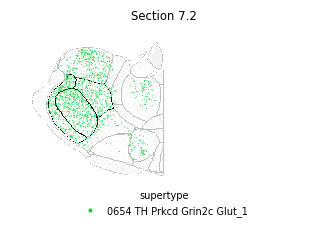

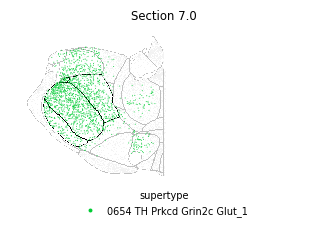

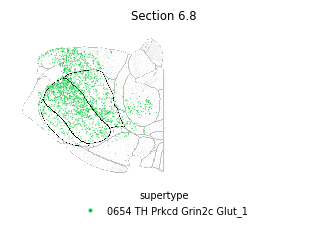

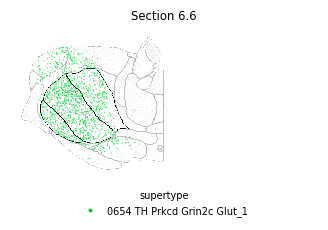

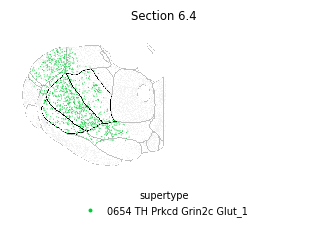

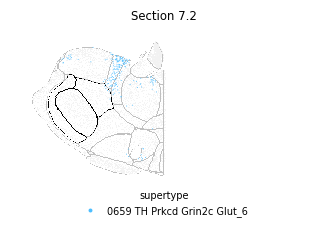

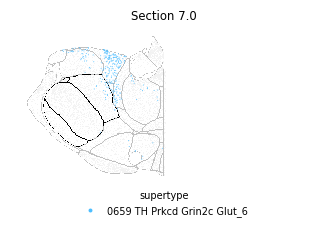

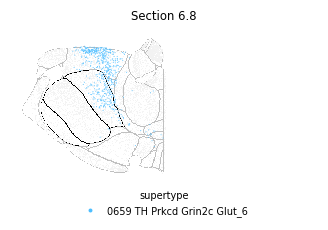

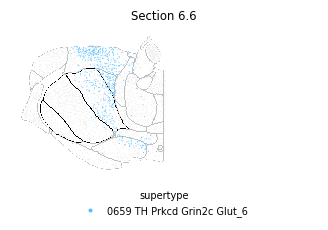

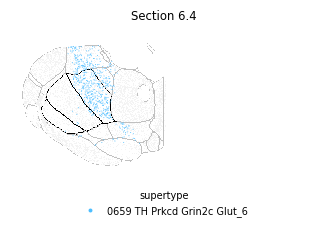

In [13]:
# Plot primary supertypes in the somatosensory nuclei
taxonomy_level = 'supertype'

obs_annot_left_st = abc.get_obs_from_annotations(
    nuclei_somatosensory, 
    adata_th_left.obs, 
    taxonomy_level=taxonomy_level,
    core_clusters_only=True
)

unique_supertypes = obs_annot_left_st['supertype'].unique()

for st in unique_supertypes:
    curr_obs_annot_left_st = obs_annot_left_st[obs_annot_left_st['supertype']==st]
    plt.rcParams.update({'font.size': 7})
    figs_annot = cplots.plot_ccf_overlay(curr_obs_annot_left_st, 
                                        ccf_images_left,
                                        boundary_img=ccf_boundaries_left,
                                        bg_cells=adata_th_left.obs, 
                                        ccf_highlight=nuclei_somatosensory,
                                        point_hue=taxonomy_level, 
                                        sections=sections_somatosensory,
                                        point_palette=abc_palettes[taxonomy_level],
                                        legend='cells',
                                        **kwargs_cell_types)
    for i, sec in enumerate(sections_somatosensory):
        sec_str = str(int(sec*10))
        figs_annot[i].savefig(
            f'{results_dir}/fig4A_supertype_{st[:4]}_annotations_z{sec_str}_somatosensory.pdf', 
            transparent=True, bbox_inches='tight'
        )
        figs_annot[i].savefig(
            f'{results_dir}/fig4A_supertype_{st[:4]}_annotations_z{sec_str}_somatosensory.png', 
            transparent=True, bbox_inches='tight', 
            dpi=1200
        )

### Figure 4B | Primary supertypes in somatosensory nuclei

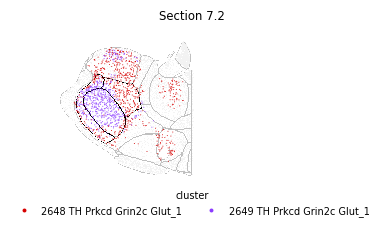

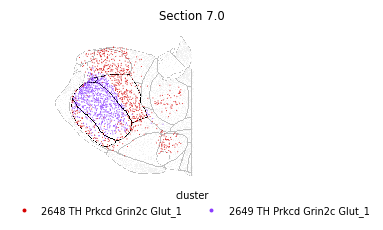

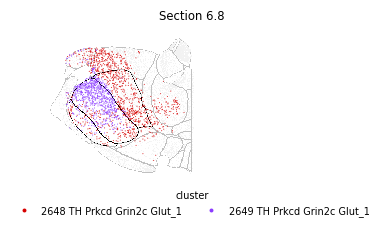

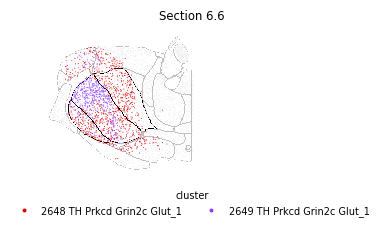

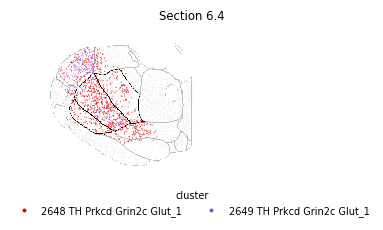

In [15]:
# Plot the clusters found in the somatosensory supertype 0654
taxonomy_level = 'cluster'
obs_annot_clust_left = abc.get_obs_from_annotations(nuclei_somatosensory, 
                                                    adata_th_left.obs, 
                                                    taxonomy_level=taxonomy_level,
                                                    core_clusters_only=True)

clusters_st0654 = [
    '2648 TH Prkcd Grin2c Glut_1', # VPL/PO
    '2649 TH Prkcd Grin2c Glut_1', # VPM
]
obs_annot_clust_left_st0654 = obs_annot_clust_left[obs_annot_clust_left['cluster'].isin(clusters_st0654)]

# Plot the clusters for supertype 654
figs_annot = cplots.plot_ccf_overlay(obs_annot_clust_left_st0654,
                                    ccf_images_left,
                                    boundary_img=ccf_boundaries_left,
                                    bg_cells=adata_th_left.obs,
                                    ccf_highlight=nuclei_somatosensory,
                                    point_hue=taxonomy_level, 
                                    sections=sections_somatosensory,
                                    point_palette=abc_palettes[taxonomy_level],
                                    legend='cells',
                                    **kwargs_cell_types)
for i, sec in enumerate(sections_somatosensory):
    sec_str = str(int(sec*10))
    figs_annot[i].savefig(f'{results_dir}/fig4B_{taxonomy_level}_2648_2649_annotations_z{sec_str}_somatosensory.pdf', 
                          transparent=True, bbox_inches='tight')
    figs_annot[i].savefig(f'{results_dir}/fig4B_{taxonomy_level}_2648_2649_annotations_z{sec_str}_somatosensory.png', 
                          transparent=True, bbox_inches='tight', dpi=1200)

## Figure 4C-D | Gene expression in the somatosensory nuclei

### Figure 4C | Spatially variable genes in the somatosensory nuclei

In [16]:
kwargs_gene_expr = dict(
    boundary_img=ccf_boundaries_left,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    cmap='Blues',
    cb_vmin_vmax=(0,5),
    point_size=0.5,
    edge_color='silver',
    edgecolors='silver',
    linewidths=0.1,
    # figsize=(1.8,1.8),
    figsize=(4,2),
    )

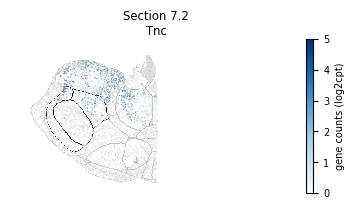

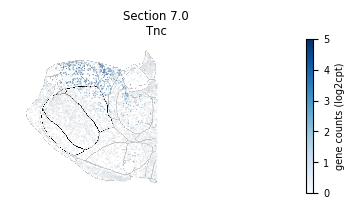

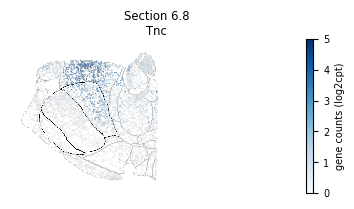

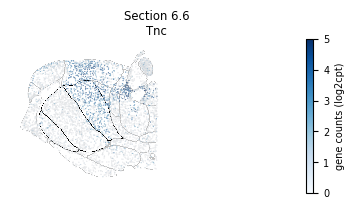

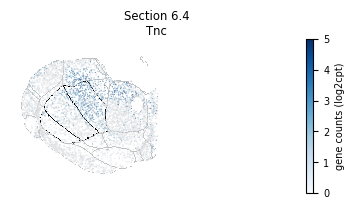

In [18]:
gene_st0659_example = 'Tnc'

fig = cplots.plot_expression_ccf(
    adata_th_left, 
    gene_st0659_example, 
    ccf_images_left,
    sections=sections_somatosensory,
    highlight=nuclei_somatosensory,
    **kwargs_gene_expr
)
for j, sec in enumerate(sections_somatosensory):
    sec_str = str(int(sec*10))
    fig[j].savefig(f'{results_dir}/fig4C_degs_somatosensory_{taxonomy_level}_{gene_st0659_example}_z{sec_str}.pdf',
                transparent=True, bbox_inches='tight', dpi=1200)
    fig[j].savefig(f'{results_dir}/fig4C_degs_somatosensory_{taxonomy_level}_{gene_st0659_example}_z{sec_str}.png',
                transparent=True, bbox_inches='tight', dpi=1200)

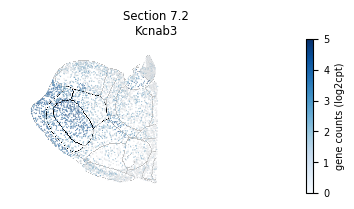

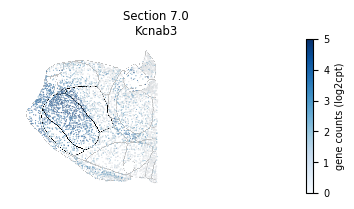

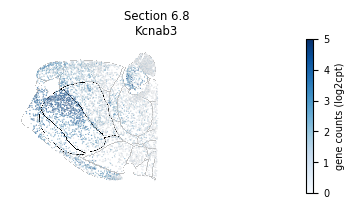

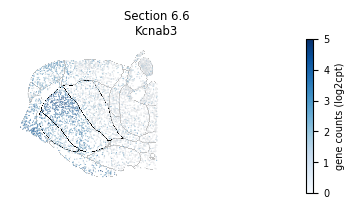

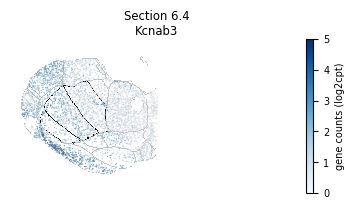

In [19]:
gene_cl2649_example = 'Kcnab3'

fig = cplots.plot_expression_ccf(
    adata_th_left, 
    gene_cl2649_example, 
    ccf_images_left,
    sections=sections_somatosensory,
    highlight=nuclei_somatosensory,
    **kwargs_gene_expr
)
for j, sec in enumerate(sections_somatosensory):
    sec_str = str(int(sec*10))
    fig[j].savefig(f'{results_dir}/fig4C_degs_somatosensory_{taxonomy_level}_{gene_cl2649_example}_z{sec_str}.pdf',
                transparent=True, bbox_inches='tight', dpi=1200)
    fig[j].savefig(f'{results_dir}/fig4C_degs_somatosensory_{taxonomy_level}_{gene_cl2649_example}_z{sec_str}.png',
                transparent=True, bbox_inches='tight', dpi=1200)

### Figure 4D | Differential Gene Expression (DEGs) between transcriptomic types

#### DEGs for supertype 0654 vs rest of cells, supertype 0659 vs rest of cells

In [20]:
supertypes_annot = adata_annot.obs['supertype'].cat.categories.to_list()
display(supertypes_annot)

['0654 TH Prkcd Grin2c Glut_1', '0659 TH Prkcd Grin2c Glut_6']

['Scn4b', 'Kcnab3', 'Rgs4', 'Rorb', 'Pvalb', 'Gpr4', 'Tcf7l2', 'St6galnac5', 'Calb1', 'Tnc']


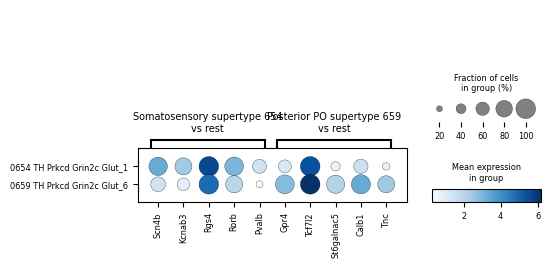

In [21]:
# Exploratory - Find top 5 DEGs for each supertype
deg_list_somatosensory_st = []
for st in supertypes_annot:
  sc.tl.rank_genes_groups(adata_annot, groupby="supertype", groups=[st],
                          reference='rest', n_genes=5, method="wilcoxon")
  deg_list_somatosensory_st.extend(sc.get.rank_genes_groups_df(adata_annot, group=st).names.to_list())

print(deg_list_somatosensory_st)

# manually set gene group labels for dotplot
var_group_positions_st = [
  [0,4], 
  [5,9], 
]
var_group_labels_st = [
  'Somatosensory supertype 654\nvs rest', 
  'Posterior PO supertype 659\nvs rest',
]
# dotplot
dotplot_st_explore = sc.pl.dotplot(adata_annot,
                                  deg_list_somatosensory_st,
                                #   sorted(list(set(deg_list_ATN))), 
                                  groupby='supertype', 
                                  dendrogram=False,
                                  cmap='Blues',
                                  var_group_positions=var_group_positions_st,
                                  var_group_labels=var_group_labels_st,
                                  var_group_rotation=0,
                                  # return_fig=True
                                  )

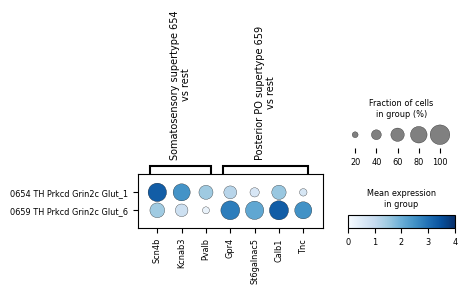

In [22]:
# Final Figure - Manually selected subset of genes
deg_list_somatosensory_st_manual = [
    'Scn4b', 'Kcnab3', 'Pvalb', # 0654
    'Gpr4', 'St6galnac5', 'Calb1', 'Tnc', # 0659
]

# manually set gene group labels for dotplot
var_group_positions_st = [
  [0,2], 
  [3,6], 
]
var_group_labels_st = [
  'Somatosensory supertype 654\nvs rest', 
  'Posterior PO supertype 659\nvs rest',
]

# dotplot
dotplot_st_curated = sc.pl.dotplot(adata_annot,
                                  deg_list_somatosensory_st_manual,
                                  groupby='supertype', 
                                  dendrogram=False,
                                  cmap='Blues',
                                  vmin=0,
                                  vmax=4,
                                  var_group_positions=var_group_positions_st,
                                  var_group_labels=var_group_labels_st,
                                  var_group_rotation=90,
                                  return_fig=True)

# save
dotplot_st_curated.savefig(f'{results_dir}/figX_degs_somatosensory_{taxonomy_level}_vs_rest_dotplot_curated.pdf', 
                          transparent=True, bbox_inches='tight')

#### DEGs for cluster 2648 vs 2649 (clusters in supertype 0654)

In [23]:
clusters_annot = [
    '2648 TH Prkcd Grin2c Glut_1',  # VPL/PO
    '2649 TH Prkcd Grin2c Glut_1',  # VPM
]

adata_annot_clust = adata_annot[adata_annot.obs['cluster'].isin(clusters_annot)].copy()

In [24]:
# Helper function to get the top DEGs for a given cluster
def get_rank_genes_list(adata, 
                        groupby='cluster', 
                        group='', 
                        reference='rest', 
                        n_genes=5):
    # find DEGs
    sc.tl.rank_genes_groups(adata, 
                            groupby="cluster", 
                            groups=[group],
                            reference=reference, 
                            n_genes=n_genes, 
                            method="wilcoxon")
    # get DEGs
    deg_list = sc.get.rank_genes_groups_df(adata, group=group).names.to_list()
    
    return deg_list

def create_var_group_positions(n_genes, deg_list):
    total_genes = len(deg_list)
    var_group_positions = []
    for i in range(0, total_genes, n_genes):
        start = i
        end = min(i + n_genes - 1, total_genes - 1)
        var_group_positions.append([start, end])
    return var_group_positions

['Calb1', 'Gpr4', 'Ramp3', 'Spon1', 'Tcf7l2', 'Kcnab3', 'Pvalb', 'Scn4b', 'Shroom3', 'Tnnt1']


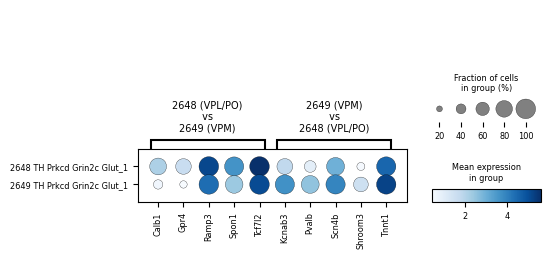

In [25]:
deg_paired_clust_list = []
n_genes = 5

# 2648 vs 2649
deg_paired_clust_list.extend(get_rank_genes_list(
  adata_annot_clust, 
  group='2648 TH Prkcd Grin2c Glut_1', 
  reference='2649 TH Prkcd Grin2c Glut_1',
  n_genes=n_genes)
)
deg_paired_clust_list.extend(get_rank_genes_list(
  adata_annot_clust, 
  group='2649 TH Prkcd Grin2c Glut_1', 
  reference='2648 TH Prkcd Grin2c Glut_1',
  n_genes=n_genes)
)
print(deg_paired_clust_list)

# set gene group labels for dotplot
var_group_positions = create_var_group_positions(n_genes, deg_paired_clust_list)
var_group_labels = [
    '2648 (VPL/PO)\n vs \n2649 (VPM)',
    '2649 (VPM)\n vs \n2648 (VPL/PO)',
]

# dotplot
dotplot_clusters_paired = sc.pl.dotplot(
    adata_annot_clust,
    deg_paired_clust_list, 
    groupby='cluster', 
    dendrogram=False,
    cmap='Blues',
    var_group_positions=var_group_positions,
    var_group_labels=var_group_labels,
    return_fig=True,
  var_group_rotation=0,
)
# save
dotplot_clusters_paired.savefig(
    f'{results_dir}/fig4D_degs_somatosensory_{taxonomy_level}_2648_vs_2649_dotplot_exploratory.pdf', 
    transparent=True, bbox_inches='tight'
)

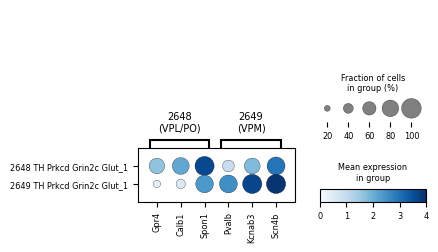

In [26]:
cluster_degs = [
    # 2648 (VPL/PO)
    'Gpr4', 'Calb1', 'Spon1', 
    # 2649 (VPM)  
    'Pvalb', 'Kcnab3', 'Scn4b',
    # # 2663 (PO/Eth)           
    # 'Gpr4', 'Adgrf5', 'Cnih3', #'Calb1', 'St6galnac5',             
]                             

var_group_positions = create_var_group_positions(n_genes=3, deg_list=cluster_degs)
var_group_labels = [
    '2648\n(VPL/PO)',
    '2649\n(VPM)',
    # '2663 (PO/Eth)',
]

dotplot_cluster_curated = sc.pl.dotplot(adata_annot_clust,
                            cluster_degs,
                            groupby='cluster', 
                            dendrogram=False,
                            cmap='Blues', #cc.cm.blues, cc.cm.CET_CBL3_r
                            vmin=0,
                            vmax=4,
                            var_group_positions=var_group_positions,
                            var_group_labels=var_group_labels,
                            var_group_rotation=0,
                            return_fig=True,
                            )

dotplot_cluster_curated.savefig(f'{results_dir}/fig4D_degs_somatosensory_{taxonomy_level}_2648_vs_2649_dotplot_curated.pdf',
                    transparent=True, bbox_inches='tight')